In [4]:
import pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt, numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import rc
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [41]:
data = pd.read_csv('parking-citations.csv')
data.columns = data.columns.str.replace(' ','')
data = data[data.IssueDate.notnull()]
data = data[['Ticketnumber', 'IssueDate']]
data.loc[:,'IssueDate'] = pd.to_datetime(data.loc[:,'IssueDate']).dt.to_period(freq='M')
data_grp = data.groupby(by='IssueDate').count()
data_grp.index = data_grp.index.to_timestamp()
total_data = data_grp[data_grp.index < '2013-09'] / data_grp[data_grp.index < '2013-09'].max()
split_pct = .9
split_ind = int(split_pct * len(total_data)) - 1

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
train_data, test_data = total_data[:split_ind], total_data[split_ind:]
print('Training Data : {} \nTesting Data : {}'.format(len(train_data), len(test_data)) )

Training Data : 36 
Testing Data : 6


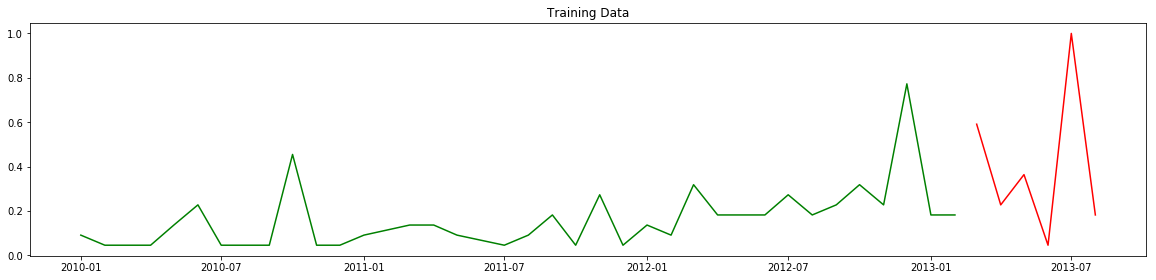

In [14]:
fig1 = plt.figure(figsize=(20,10))
gs = fig1.add_gridspec(4, 2, hspace = 1)
f1_ax1 = fig1.add_subplot(gs[0:2, :], title='Training Data')

f1_ax1.plot(train_data, color = 'g')
f1_ax1.plot(test_data, color = 'r')

In [18]:
_  = train_data - train_data.shift(1)
train_data_shift = _[1:]
train_data_shift = train_data_shift.Ticketnumber

In [19]:
print(sm.tsa.adfuller(train_data_shift))
try:
    model = sm.tsa.ARIMA(train_data, order=(3,1,2)).fit(disp=-1)
except:
    model = None
    pass

(-5.907281408748917, 2.690002815842242e-07, 3, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, -20.309048155028172)


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [20]:
x = train_data.index[-7:]
x = x.shift(8, freq='M')
x = x.to_period('M').to_timestamp()
pred_Series = model.predict(train_data.shape[0], train_data.shape[0]+6).values
pred_Series = pd.Series(pred_Series, index=x)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


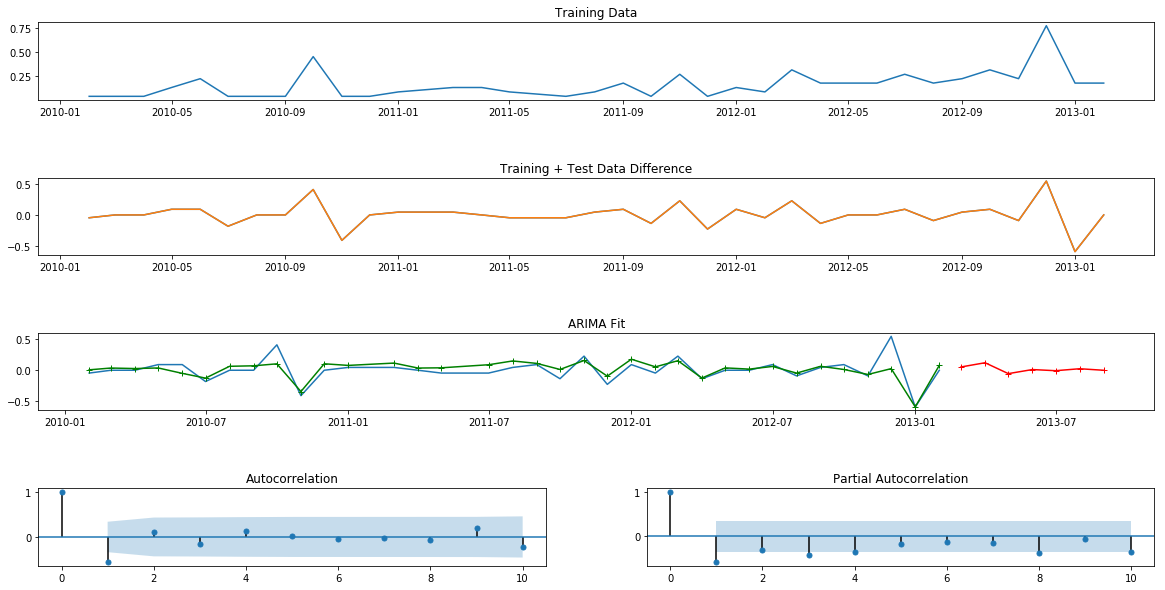

In [21]:
fig2 = plt.figure(figsize=(20,10))
gs2 = fig2.add_gridspec(4, 2, hspace=1)
f2_ax1 = fig2.add_subplot(gs2[0, :], title='Training Data')
f2_ax2 = fig2.add_subplot(gs2[1, :], title='Training + Test Data Difference')
f2_ax3 = fig2.add_subplot(gs2[2, :], title='ARIMA Fit')
f2_ax4 = fig2.add_subplot(gs2[3, 0])
f2_ax5 = fig2.add_subplot(gs2[3, 1])

f2_ax1.plot(train_data[1:])
f2_ax2.plot(train_data_shift[:])
f2_ax2.plot(train_data_shift[:])
f2_ax3.plot(train_data_shift[:])
f2_ax3.plot(model.fittedvalues, color='g', marker='+')
f2_ax3.plot(pred_Series, color='r', marker='+')

x = plot_acf(train_data_shift[1:], ax=f2_ax4, lags=10)
y = plot_pacf(train_data_shift[1:], ax=f2_ax5, lags=10)

In [22]:
pred_val = model.fittedvalues.append(pred_Series)

In [35]:
train_data.Ticketnumber[0]

0.09090909090909091

In [30]:
pred_val_cumsum = pred_val
step_preds_diff1 = pd.Series(train_data.Ticketnumber[0], index=pred_val.index)
step_preds_diff2 = step_preds_diff1.add(pred_val_cumsum.values)

In [31]:
san_check = train_data_shift

In [32]:
j = pd.Series(train_data.Ticketnumber[0], index=train_data.index)

In [33]:
nums = j[1:].add(san_check.values)

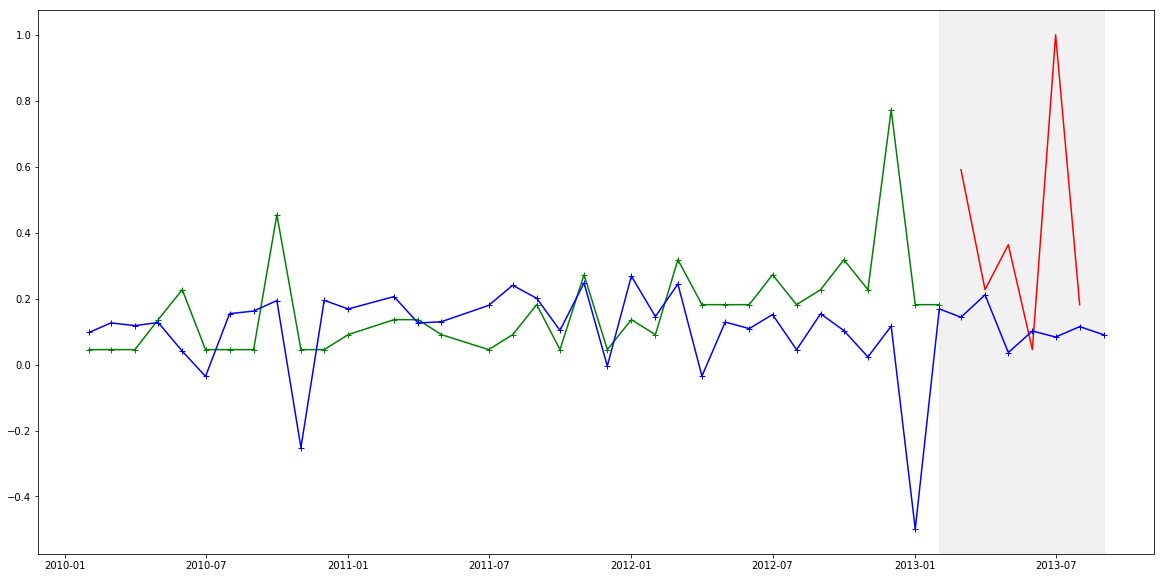

In [40]:
fig3 = plt.figure(figsize=(20,10))
plt.plot(train_data[1:], color = 'g', marker = '+')
plt.plot(test_data, color='r')
plt.axvspan(train_data.index[-1], step_preds_diff2.index[-1], alpha=0.3, color='lightgrey')
plt.plot(step_preds_diff2 , color='b', marker = '+')
#plt.plot(total_data[total_data.index.isin(accel[abs(accel.Ticketnumber) > 1.5].index)], color = 'r', marker='o')
#plt.plot(total_data[total_data.index.isin(accel_test[abs(accel_test.Ticketnumber) > 1.5].index)], color = 'r', marker='o')